◼ **Classificação das doenças nas plantas**

◼ **Importando módulos**

In [49]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from zipfile import ZipFile
import splitfolders
import cv2

◼ **Caminho das imagens**

In [5]:
root_path= os.path.join("data/plantsvillage.zip")

◼ **Extrair as imagens do arquivo .zip**

In [6]:
with ZipFile(root_path, 'r') as zipObj:
  zipObj.extractall()
  print('Done')

Done


◼ **Criar uma lista das classes**

In [8]:
classes_train = sorted(list(filter(lambda x: os.path.isdir('plantsvillage/' + x), os.listdir('plantsvillage'))))


◼ **Exibir os nomes de todas as classes**

In [9]:
print(classes_train)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


**TEXTO**

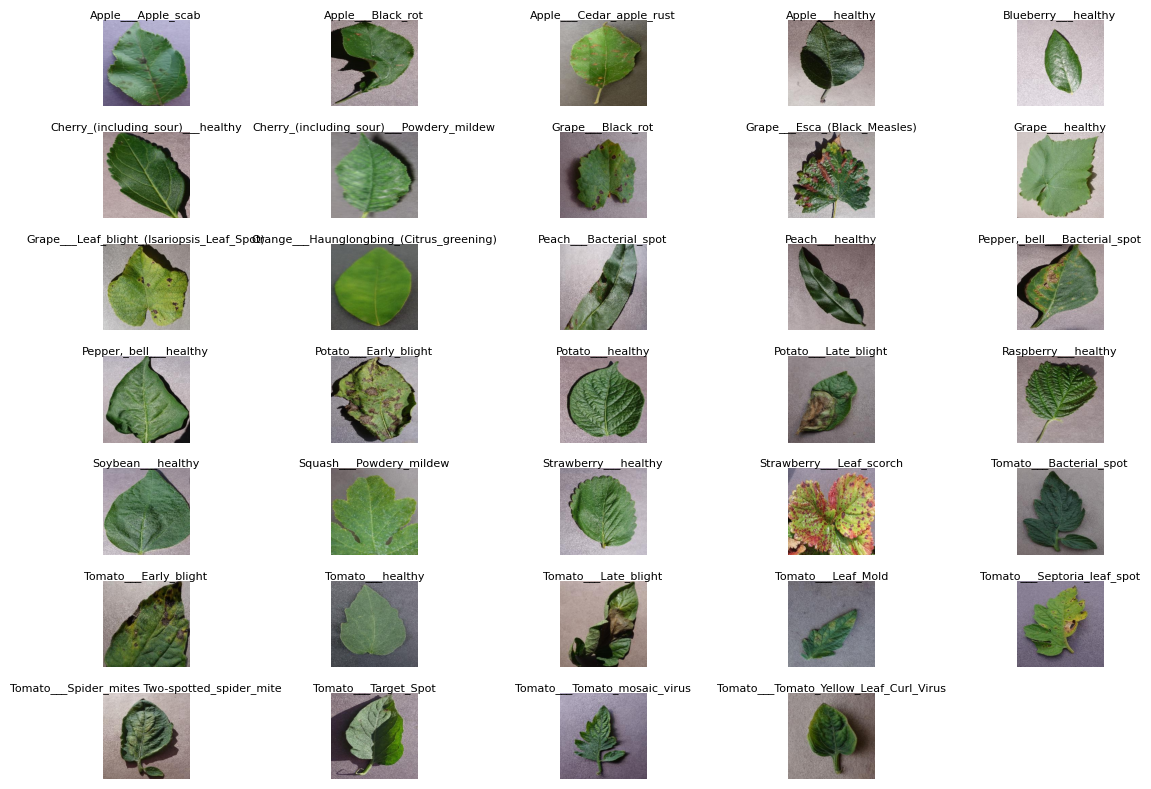

In [45]:

# Diretório contendo as classes (pastas)
diretorio = os.path.join("plantsvillage/")

# Obtém a lista de pastas (classes)
classes = os.listdir(diretorio)

# Calcula o número de linhas e colunas para a grade
num_linhas = 7  # Escolha o número de linhas desejado
num_colunas = (len(classes) + num_linhas - 1) // num_linhas

# Configura a plotagem
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(12, 8))
axs = axs.ravel()  # Transforma a matriz de subplots em um vetor

# Itera sobre as classes
for i, classe in enumerate(classes):
    # Obtém o caminho para uma imagem da classe atual
    classe_dir = os.path.join(diretorio, classe)
    imagem = os.listdir(classe_dir)[0]  # Seleciona a primeira imagem
    imagem_path = os.path.join(classe_dir, imagem)

    # Lê e exibe a imagem
    img = mpimg.imread(imagem_path)
    axs[i].imshow(img)
    axs[i].axis('off')

    # Exibe o nome da classe
    axs[i].set_title(classe, fontsize=8, pad=2, ha='center')

# Remove subplots não utilizados
for j in range(len(classes), num_linhas * num_colunas):
    fig.delaxes(axs[j])

# Ajusta automaticamente o espaçamento entre os subplots
plt.tight_layout()

# Exibe o plot
plt.show()


◼ **Dividir as classes em treino e validação**

In [11]:
input_folder='plantsvillage'
splitfolders.ratio(input_folder, output="output", seed=1337, ratio=(.8,.2))

◼ **Parâmetros de funções callback**

In [19]:
batch_size = 128
learning_rate = 0.0005
epochs = 12

◼ **Gerar novas imagens**
- ImageDataGenerator é uma classe da biblioteca Keras do TensorFlow que permite gerar automaticamente novas imagens com base em um conjunto de imagens existentes.

train_datagen:
- Cria um objeto redimensionando os valores dos pixels das imagens para o intervalo entre 0 e 1

train_generator:
- Dados de treinamento

val_generator:
- Dados de validação

**Importante**
- Esses geradores de dados são utilizados para fornecer lotes de imagens e seus rótulos associados durante o treinamento e a validação do modelo de rede neural. O uso de geradores é útil para lidar com conjuntos de dados grandes, pois permite carregar e processar os dados em lotes, economizando memória e facilitando o treinamento em lotes da rede neural.

In [14]:
train_datagen=ImageDataGenerator(rescale=1/255)
train_generator=train_datagen.flow_from_directory(
    'output/train',
    target_size=(200, 200),
    batch_size=batch_size,
    classes = classes_train,
    class_mode='categorical'
)
val_datagen=ImageDataGenerator(rescale=1/255)
val_generator=val_datagen.flow_from_directory(
    'output/val',
    target_size=(200, 200),
    batch_size=batch_size,
    classes = classes_train,
    class_mode='categorical'
)

Found 40345 images belonging to 34 classes.
Found 10103 images belonging to 34 classes.


◼ **Modelo de rede neural convolucional utilizando a API Sequencial do Keras**

In [28]:
model = tf.keras.models.Sequential([
    # A forma de entrada é o tamanho desejado da imagem 200x 200 com cor de 3 bytes
    # Primeira convolução
    # Utiliza 16 filtros de tamanho 3x3, função de ativação ReLU e input_shape de (200, 200, 3) para imagens coloridas.
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)),
    # Camada de normalização em lote (Batch Normalization): Normaliza os valores das ativações da camada anterior
    tf.keras.layers.BatchNormalization(),
    # Camada de MaxPooling 2D: Reduz a dimensionalidade da saída pela metade usando uma janela de tamanho 2x2
    tf.keras.layers.MaxPooling2D(2, 2),
    # Segunda convolução
    # Repetições de camadas, normalização e maxPooling para aprofundar a rede.
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),    
    tf.keras.layers.MaxPooling2D(2,2),
    # Terceira convolução
    # Repetições de camadas, normalização e maxPooling para aprofundar a rede.
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # Quarta convolução
    # Repetições de camadas, normalização e maxPooling para aprofundar a rede.
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # Quinta convolução
    # Repetições de camadas, normalização e maxPooling para aprofundar a rede.
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # Achata os resultados para alimentar uma camada densa
    tf.keras.layers.Flatten(),
    # 128 neurônios na camada totalmente conectada
    tf.keras.layers.Dense(128, activation='relu'),
    # 34 neurônios correspondendo as classes de saída com a função de ativação softmax
    tf.keras.layers.Dense(34, activation='softmax')
])

◼ **Resumo da rede neural**

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 198, 198, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 97, 97, 32)       128       
 hNormalization)                                                 
                                                        

◼ **Compilação do modelo neural**

Nessa etapa, são definidos o otimizador, a função de perda (loss)
e as métricas de avaliação que serão utilizados durante o treinamento:

- A função de perda escolhida é a "categorical_crossentropy", que é comumente utilizada em problemas de classificação com múltiplas classes. Essa função de perda é adequada para problemas em que as classes são exclusivas e mutuamente excludentes.


- O otimizador escolhido é o Adam, que é um algoritmo de otimização popular e eficiente. 

- A métrica de avaliação escolhida é a acurácia (accuracy), que é uma métrica comum para problemas de classificação.
Ela mede a proporção de predições corretas em relação ao total de amostras.

In [26]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy']
    )

**Determinar o número de etapas a serem executadas durante o treinamento e validação do modelo**

steps_per_epoch:

- train_generator.n = Número total de amostras no conjunto de treinamento.
- train_generator.batch_size = Tamanho do lote (batch size) usado durante o treinamento.

A divisão train_generator.n // train_generator.batch_size calcula o número de lotes (batches) completos que podem ser formados a partir do conjunto de treinamento. Isso define o número de etapas (steps) a serem executadas durante cada época (epoch) de treinamento. Cada etapa envolve a passagem de um lote (batch) de dados pelo modelo para atualização dos pesos.


validation_steps:
- val_generator.n: Número total de amostras no conjunto de validação.
- val_generator.batch_size: Tamanho do lote (batch size) usado durante a validação.


A divisão val_generator.n // val_generator.batch_size calcula o número de lotes (batches) completos que podem ser formados a partir do conjunto de validação. Isso define o número de etapas (steps) a serem executadas durante a validação.




In [23]:
steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps=val_generator.n//val_generator.batch_size

◼ **ModelCheckpoint**

In [25]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "save_points/pcd.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto')


◼ **Treinar o modelo**

**Importante**

Uma lista de objetos de callback podem ser são usados durante o treinamento para realizar ações específicas:
- (ReduceLROnPlateau) - Ajustar a taxa de aprendizado
- (EarlyStopping) - Parar o treinamento antecipadamente se a perda não estiver melhorando (EarlyStopping)
- (ModelCheckpoint) - Salvar o modelo (em um arquivo de ponto de verificação) em algum intervalo, para que o modelo possa ser carregado posteriormente para continuar o treinamento do estado salvo.

In [27]:
history=model.fit(
    x=train_generator,
    y=None,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint]
)

Epoch 1/12
315/315 [==============================] - ETA: 0s - loss: 0.9657 - accuracy: 0.7271
Epoch 1: val_loss improved from inf to 5.79085, saving model to pcd.h5
315/315 [==============================] - 642s 2s/step - loss: 0.9657 - accuracy: 0.7271 - val_loss: 5.7909 - val_accuracy: 0.0944
Epoch 2/12
315/315 [==============================] - ETA: 0s - loss: 0.3066 - accuracy: 0.9054
Epoch 2: val_loss improved from 5.79085 to 0.40961, saving model to pcd.h5
315/315 [==============================] - 587s 2s/step - loss: 0.3066 - accuracy: 0.9054 - val_loss: 0.4096 - val_accuracy: 0.8698
Epoch 3/12
315/315 [==============================] - ETA: 0s - loss: 0.1825 - accuracy: 0.9415
Epoch 3: val_loss improved from 0.40961 to 0.40062, saving model to pcd.h5
315/315 [==============================] - 593s 2s/step - loss: 0.1825 - accuracy: 0.9415 - val_loss: 0.4006 - val_accuracy: 0.8761
Epoch 4/12
315/315 [==============================] - ETA: 0s - loss: 0.1131 - accuracy: 0.9648

◼ **Exibibir a performance do modelo**

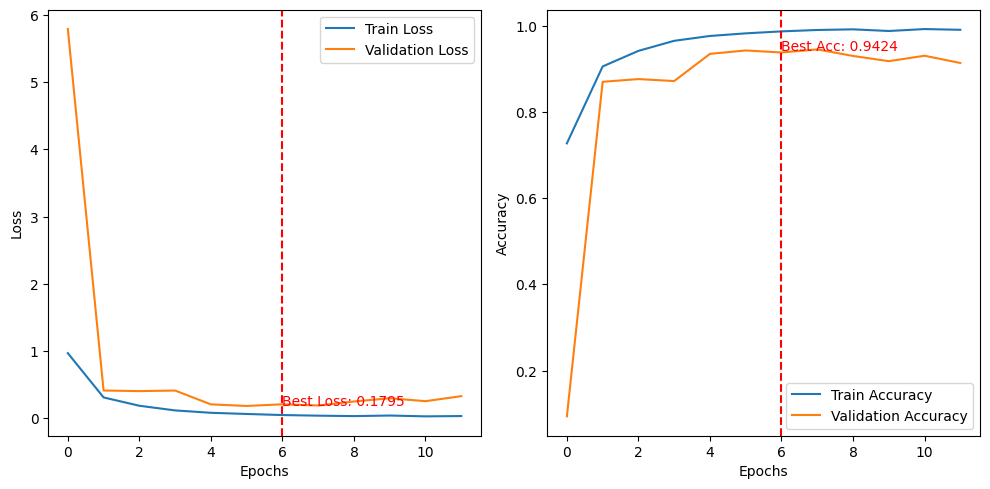

In [46]:
# Obtenha as métricas de treinamento do histórico
train_loss = history.history['loss']
train_acc = history.history['accuracy']

# Obtenha as métricas de validação do histórico
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Crie o gráfico
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

best_epoch = np.argmin(val_loss) + 1
best_val_loss = val_loss[best_epoch - 1]
best_val_acc = val_acc[best_epoch - 1]

# Destaque a melhor época no gráfico
plt.subplot(1, 2, 1)
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
plt.text(best_epoch, best_val_loss, f'Best Loss: {best_val_loss:.4f}', color='r')

plt.subplot(1, 2, 2)
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
plt.text(best_epoch, best_val_acc, f'Best Acc: {best_val_acc:.4f}', color='r')

plt.tight_layout()
plt.show()


◼ **Avaliação do desempenho**

- O método evaluate() é usado para avaliar o desempenho de um modelo de rede neural em um conjunto de dados de teste.

In [48]:
model = tf.keras.models.load_model('save_points/pcd.h5')
model.evaluate(val_generator)

79/79 [==============================] - 31s 387ms/step - loss: 0.1792 - accuracy: 0.9425


[0.17924249172210693, 0.9424923062324524]

◼ **Salvar o modelo**

In [47]:
keras.models.save_model(model, "model.h5")

◼ **Converter modelo para formato do TensorFlow Lite**

In [53]:
## For TFLite model
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()
open('models/model.tflite', 'wb').write(tflite_model)
## For TFLite optimized model
converter.optimizations=[tf.lite.Optimize.DEFAULT]
tflite_opt_model=converter.convert()
open('models/model_opt.tflite', 'wb').write(tflite_opt_model)

INFO:tensorflow:Assets written to: C:\Users\rodri\AppData\Local\Temp\tmp_opnt8u5\assets


INFO:tensorflow:Assets written to: C:\Users\rodri\AppData\Local\Temp\tmp_opnt8u5\assets


INFO:tensorflow:Assets written to: C:\Users\rodri\AppData\Local\Temp\tmpltbs5war\assets


INFO:tensorflow:Assets written to: C:\Users\rodri\AppData\Local\Temp\tmpltbs5war\assets


245360